In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.linalg import dft
n_pts = 2**5
dx = 0.6
dp = 2*np.pi/n_pts/dx
p = np.empty(n_pts, dtype=float)
for i in range(n_pts):
    p[i] = dp*i - (n_pts//2)*dp
ptot = np.diag(p**2)
dftmat = dft(n_pts, 'sqrtn')
p2mat= 1/2*np.diag(ptot)
tfft = np.transpose(np.conj(dftmat))@np.diag(p2mat)@dftmat

In [2]:
fvals = pd.read_csv('func.csv')
dens = pd.read_csv('dens.csv')
ddens = pd.read_csv('ddens.csv')
dddens = pd.read_csv('dddens.csv')
eners = pd.read_csv('ener_noise_start.csv')
enerse = pd.read_csv('exact_ener.csv')
vks = pd.read_csv('vks_noise_start.csv')
#times_qc = pd.read_csv('times_qc.csv')
#dens_qc = pd.read_csv('dens_qc.csv')
print(eners['0'][2000])


-1.9172659925855404


In [3]:
#times_qc = times_qc['0'].to_numpy()
npts = len(dens['17']) -1
times = np.linspace(0, npts*0.012, npts+1)
th = np.linspace(0, 1, npts+1)
print(times[2000])
print(times[0:npts+1:1000])

24.0
[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144.]


In [28]:
xvals = np.linspace(-9.3, 9.3, n_pts)
diff = np.zeros(npts+1)
for i in range(npts+1):
    _, v = np.linalg.eigh(tfft+np.diag(vks.loc[i,:].to_numpy()[1:]))
    diff[i] = np.linalg.norm((2*np.abs(v[:,0])**2-dens.loc[i,:].to_numpy()[1:]))



In [29]:
diff[2500]

0.0014299277168581045

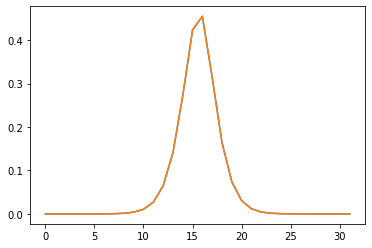

In [30]:
_, v = np.linalg.eigh(tfft+np.diag(vks.loc[2000,:].to_numpy()[1:]))
plt.plot(list(range(32)), np.abs(v[:,0])**2*2, list(range(32)), dens.loc[2000,:].to_numpy()[1:])

Text(0.5, 0, 'R (a.u.)')

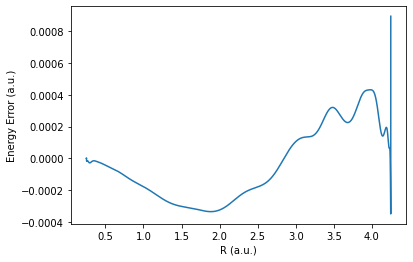

In [31]:
s01=-20*th**7 + 70*th**6 - 84*th**5 + 35*th**4
#s01 = 6*th**5-15*th**4+10*th**3
lam_eh = 0.7
lam_eli = 2.25

def vpot(xpts, r):
    return -1/np.sqrt((xpts-r/2)**2+lam_eh)-1/np.sqrt((xpts+r/2)**2+lam_eli)

#print(1/np.sqrt((0*(4.25-0.25)+0.25)**2+2.35)+eners['0'][0])
rs = s01*(4.25-0.25)+0.25
nevals = 1/np.sqrt((rs)**2+2.35)
plt.plot(rs, nevals+eners['0']-(nevals+enerse['0']))#, rs, 1/np.sqrt((rs)**2+2.35)+enerse['0'])
plt.ylabel('Energy Error (a.u.)')
plt.xlabel('R (a.u.)')

Text(0, 0.5, 'Density Error (a.u.)')

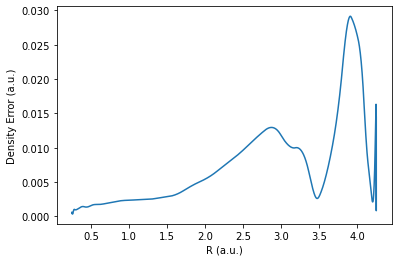

In [32]:
plt.plot(rs[1:], diff[1:])
plt.xlabel('R (a.u.)')
plt.ylabel('Density Error (a.u.)')

(0.0, 1.0)

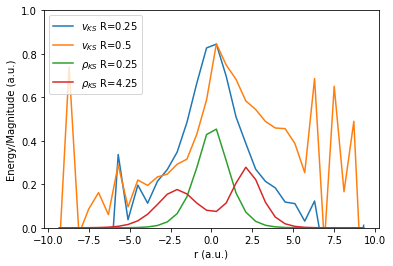

In [9]:
s01=-20*th**7 + 70*th**6 - 84*th**5 + 35*th**4
#s01 = 6*th**5-15*th**4+10*th**3
lam_eh = 0.7
lam_eli = 2.25

def vpot(xpts, r):
    return -1/np.sqrt((xpts-r/2)**2+lam_eh)-1/np.sqrt((xpts+r/2)**2+lam_eli)

#print(1/np.sqrt((0*(4.25-0.25)+0.25)**2+2.35)+eners['0'][0])
rs = s01*(4.25-0.25)+0.25
nevals = 1/np.sqrt((rs)**2+2.35)
plt.plot(xvals,vks.loc[1,:].to_numpy()[1:]-vpot(xvals,0.25)+0.68,
         xvals, vks.loc[12000,:].to_numpy()[1:]-vpot(xvals, 4.25)+0.68,
         xvals,dens.loc[0,:].to_numpy()[1:],
         xvals, dens.loc[12000,:].to_numpy()[1:])
plt.ylabel('Energy/Magnitude (a.u.)')
plt.xlabel('r (a.u.)')
plt.legend([r"$v_{KS}$ R=0.25", r"$v_{KS}$ R=0.5", r"$\rho_{KS}$ R=0.25", r"$\rho_{KS}$ R=4.25"])
plt.ylim((0., 1.))

In [10]:
from scipy import interpolate
import numpy as np
rng = np.random.default_rng()

tck = interpolate.splrep(times[0:npts+1:100], dens["16"][0:npts+1:100],k=4)
xnew = times[0:npts+1:1]
ynew = interpolate.splev(xnew, tck, der=0)

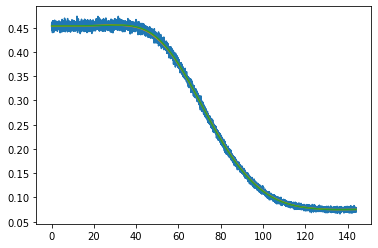

In [19]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
#npts = len(range(0,npts+1,1))
ynoise = dens["16"][0:npts+1:1]+rng.standard_normal(npts+1)*np.sqrt(dens['16']*(1-dens['16'])/10000)
xnoise = times[0:npts+1:1]
z = lowess(ynoise,xnoise,1/12)
plt.plot(xnoise,ynoise,z[:,0], z[:,1], times, dens["16"])

32


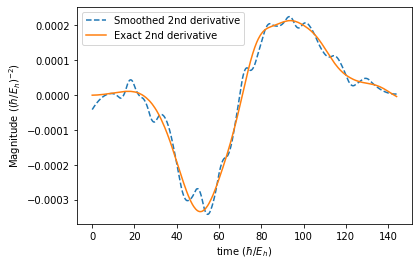

In [22]:
tck = interpolate.splrep(ntimes, ndens,k=5)
#tck = interpolate.splrep(times_qc, 2*dens_qc["16"], k=4)
tck = interpolate.splrep(z[:npts:300,0], z[:npts:300,1],k=4)
xnew = times[0:npts+1:1]
print(n_pts)
ynew = interpolate.splev(xnew, tck, der=2)
plt.plot(xnew, ynew, '--', times, dddens["16"])
plt.xlabel("time ($\hbar/E_h$)")
plt.ylabel("Magnitude ($(\hbar/E_h)^{-2}$)")
plt.legend(["Smoothed 2nd derivative", "Exact 2nd derivative"])

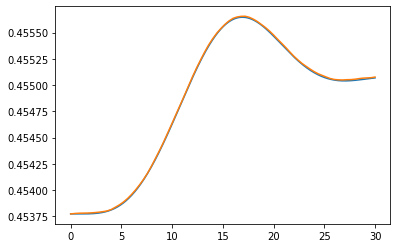

In [88]:
plt.plot(times, dens["16"], times_qc, 2*dens_qc["16"])#-ynew)#, z[:,0], z[:,1])

[0.45377395 0.45377396 0.4537741  0.45377488 0.45377713 0.45378194
 0.45379053 0.45380428 0.45382473 0.45385351 0.45389233 0.4539428
 0.45400639 0.45408442 0.45417782 0.45428697 0.45441161 0.45455074
 0.45470244 0.45486357 0.45502962 0.45519458 0.45535097 0.45548961
 0.45559934 0.45566695 0.45567692 0.45561136 0.45544988 0.45516973
 0.45474584 0.45415094 0.45335571 0.45232903 0.45103858 0.44945161
 0.44753561 0.44525907 0.44259235 0.43950871 0.43598519 0.43200348
 0.42755064 0.42261966 0.41720977 0.41132636 0.40498049 0.39818839
 0.39097078 0.38335205 0.37535939 0.36702204 0.3583707  0.34943734
 0.3402552  0.33085909 0.32128568 0.31157397 0.3017654  0.29190359
 0.28203356 0.27220066 0.26244921 0.25282095 0.24335368 0.23408008
 0.22502706 0.21621558 0.20766111 0.19937449 0.19136306 0.18363193
 0.1761852  0.1690267  0.16216039 0.15559043 0.14932082 0.14335498
 0.13769527 0.13234263 0.12729638 0.12255427 0.11811261 0.11396655
 0.11011029 0.10653714 0.10323964 0.1002093  0.09743648 0.09491

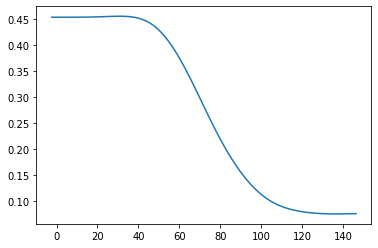

In [14]:
#print(ntimes)
ntimes = np.array([-2.4,-1.2]+list(times[0:npts+1:100])+[times[-1]+1.2, times[-1]+2.4])
print(dens["16"][0:npts+1:100].to_numpy())
ndens = np.array([dens["16"][0]]*2+list(dens["16"][0:npts+1:100].to_numpy())+[dens["16"][npts]]*2)
plt.plot(ntimes,ndens)

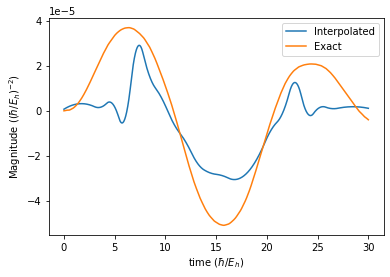

In [90]:

tck = interpolate.splrep(times_qc, 2*dens_qc["16"].to_numpy(),k=4)
tck = interpolate.splrep(z[np.ix_(list(range(0,npts+1,100)),[0])], z[np.ix_(list(range(0,npts+1,100)),[1])],k=4)
xnew = times[0:npts+1:1]
ynew = interpolate.splev(xnew, tck, der=2)
plt.plot(xnew, ynew, times, dddens["16"])
plt.xlabel("time ($\hbar/E_h$)")
plt.ylabel("Magnitude ($(\hbar/E_h)^{-2}$)")
plt.legend(["Interpolated", "Exact"])

In [13]:
xpts = np.linspace(0, 1, 21)
print(xpts)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [14]:
import numpy as np
import scipy as sc

v=[[1,1,1,1],[7,6,5,4],[7*6,6*5,5*4,4*3], [7*6*5,6*5*4,5*4*3,4*3*2]]
vmat = np.array(v)
c=np.linalg.inv(vmat)@np.array([1,0,0,0])
print(c)

[-20.  70. -84.  35.]


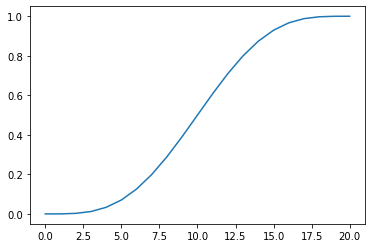

In [17]:
plt.plot(c[0]*xpts**7+c[1]*xpts**6+c[2]*xpts**5+c[3]*xpts**4)

In [18]:
c[0]*xpts**7+c[1]*xpts**6+c[2]*xpts**5+c[3]*xpts**4

array([0.00000000e+00, 1.93578125e-04, 2.72800000e-03, 1.21031719e-02,
       3.33440000e-02, 7.05566406e-02, 1.26036000e-01, 1.99845734e-01,
       2.89792000e-01, 3.91712203e-01, 5.00000000e-01, 6.08287797e-01,
       7.10208000e-01, 8.00154266e-01, 8.73964000e-01, 9.29443359e-01,
       9.66656000e-01, 9.87896828e-01, 9.97272000e-01, 9.99806422e-01,
       1.00000000e+00])

In [19]:
1-(c[0]*xpts**7+c[1]*xpts**6+c[2]*xpts**5+c[3]*xpts**4)

array([ 1.00000000e+00,  9.99806422e-01,  9.97272000e-01,  9.87896828e-01,
        9.66656000e-01,  9.29443359e-01,  8.73964000e-01,  8.00154266e-01,
        7.10208000e-01,  6.08287797e-01,  5.00000000e-01,  3.91712203e-01,
        2.89792000e-01,  1.99845734e-01,  1.26036000e-01,  7.05566406e-02,
        3.33440000e-02,  1.21031719e-02,  2.72800000e-03,  1.93578125e-04,
       -7.10542736e-15])

In [22]:
v=[[1,1,1,1,1],[9,8,7,6,5],[9*8,8*7,7*6,6*5,5*4], [9*8*7,8*7*6,7*6*5,6*5*4,5*4*3], [9*8*7*6,8*7*6*5,7*6*5*4,6*5*4*3,5*4*3*2]]
vmat = np.array(v)
c=np.linalg.inv(vmat)@np.array([1,0,0,0,0])
print(c)

[  70. -315.  540. -420.  126.]


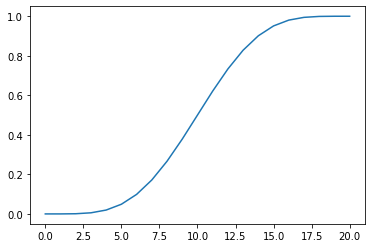

In [21]:
plt.plot(c[0]*xpts**9+c[1]*xpts**8+c[2]*xpts**7+c[3]*xpts**6+c[4]*xpts**5)

In [15]:
v=[[1,1,1,1,1,1],[-1,1,-1,1,-1,1],[1,2,3,4,5,6],[1,-2,3,-4,5,-6],[0,2,3*2,4*3,5*4,6*5],[0,2,-3*2,4*3,-5*4,6*5]]
vmat = np.array(v)
cs=np.linalg.inv(vmat)@np.array([1/2,-1/2,0,0,0,0])

0.9375000000000003 15/16
-1.1102230246251565e-16 0
-0.6250000000000002 -5/8
0.0 0
0.18750000000000006 3/16
0.0 0


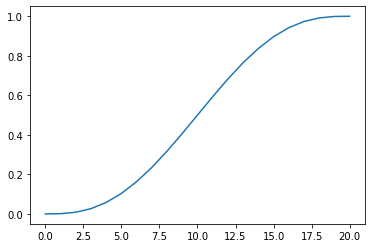

In [30]:
xpts = np.linspace(0, 1, 21)
from fractions import Fraction
v = np.ones(len(xpts))/2
for i, ci in enumerate(cs):
    print(ci,Fraction(ci).limit_denominator(1000))
    v += ci*(xpts*2-1)**(i+1)

plt.plot(v)

In [38]:
from sympy import poly, Rational, terms_gcd, integrate, diff, simplify, sqrt
from sympy.abc import x,y
p=terms_gcd(Rational(1,2)+Rational(15,16)*(2*x-1)-(Rational(5,8)*(2*x-1)**3)+Rational(3,16)*(2*x-1)**5)
p2 = terms_gcd((-2*((2*x-1))**2+((2*x-1))**4+1)/(Rational(16,5)-8+Rational(16,3)))


In [45]:
diff(-1/sqrt(Rational(7,10)+(x-y/2)**2)-1/sqrt(Rational(9,4)+(x+y/2)**2), y)

-(-x/2 - y/4)/((x + y/2)**2 + 9/4)**(3/2) - (x/2 - y/4)/((x - y/2)**2 + 7/10)**(3/2)

In [50]:
simplify(diff(-1/sqrt(Rational(7,10)+(x+y/2)**2), y)-(x+y/2)/sqrt(Rational(7,10)+(x+y/2)**2)**3/2)

0

In [312]:
simplify(diff(p2,x))

60*x*(2*x**2 - 3*x + 1)

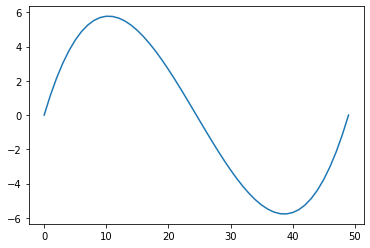

In [313]:
plt.plot(60*xvals*(2*xvals**2-3*xvals+1))

In [11]:
import numpy as np
import scipy as sc

v=[[1,1],[3,2]]
vmat = np.array(v)
c=np.linalg.inv(vmat)@np.array([1,0])
print(c)

[-2.  3.]


-2.4492935982947064e-16

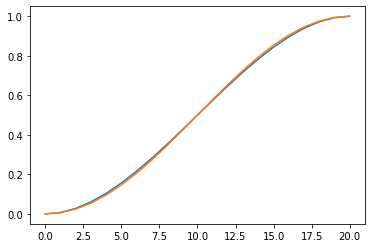

In [42]:
xpts = np.linspace(0, 1, 21)
plt.plot(-2*xpts**3+3*xpts**2)
plt.plot((1-np.cos(np.pi*xpts))/2)
np.sin(2*np.pi)